In [1]:
from verification_net import VerificationNet
from model_trainer import ModelTrainer
from autoencoder import AutoEncoder

from utils import top_anomalous, top_mean_anomalous, errorbar_classification

from stacked_mnist import StackedMNIST, DataMode

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader

from tqdm import tqdm
import matplotlib.pyplot as plt

from pathlib import Path
from typing import Tuple

In [3]:
device = torch.device("mps")
torch.mps.set_per_process_memory_fraction(0.)

trainer_file = Path("trainers/ae-anom.pkl")
model_file = Path("models/ae-anom")

In [4]:
class AutoEncoderTrainer(ModelTrainer):
    def __init__(
            self, 
            model, 
            loss, 
            optimizer,
            device = torch.device("mps"),
            file_name: str | Path = model_file, 
            force_learn: bool = False
        ) -> None:
        super().__init__(model, loss, optimizer, device, file_name, force_learn)

    def get_output_from_batch(self, batch):
        x, _, _ = batch
        x = x.to(self.device)
        _, output = self.model(x)
        return x, output

In [5]:
latent_space_size = 64
mode = DataMode.MONO

In [6]:
AE = AutoEncoder(latent_space_size=latent_space_size)
loss = nn.MSELoss()
opt = optim.Adam(AE.parameters(), lr=1e-5)

In [7]:
trainset = StackedMNIST(train=True, mode=mode | DataMode.MISSING)
testset = StackedMNIST(train=False, mode=mode)

/Users/arthurtestard/envs/ntnu/deeplearning/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [8]:
Trainer = AutoEncoderTrainer(
        model=AE, 
        loss=loss, 
        optimizer=opt, 
        file_name=model_file,
        force_learn=False
    )

In [9]:
Trainer = Trainer.load_trainer(trainer_file)

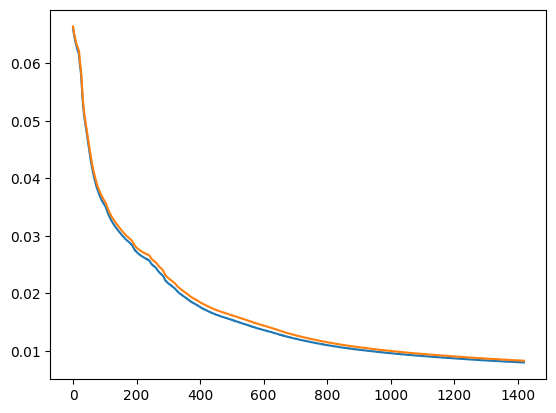

In [10]:
plt.plot(Trainer.losses, label="train loss")
plt.plot(Trainer.val_losses, label="val loss")

In [11]:
train_set = DataLoader(trainset, shuffle=True, batch_size=2048)
test_set = DataLoader(testset, shuffle=True, batch_size=2048)

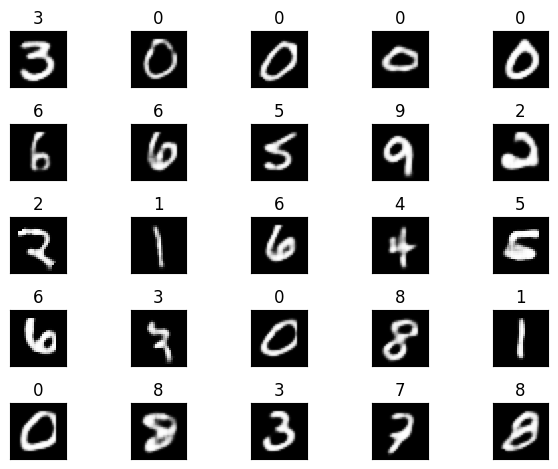

In [12]:
Trainer.print_reconstructed_img(testset)

In [13]:
VerifNet = VerificationNet(file_name='models/verification_model_torch_ok_copy')

In [14]:
Trainer.print_class_coverage_and_predictability(VerifNet, trainset)

Coverage: 100.00%
Predictability: 99.27%
Accuracy: 97.50%


In [15]:
Trainer.print_class_coverage_and_predictability(VerifNet, testset)

Coverage: 100.00%
Predictability: 98.97%
Accuracy: 95.74%


In [16]:
def calculate_class_accuracies(X, X_hat, labels):
    class_accuracies = [[] for _ in range(10)]

    for x, x_hat, label in zip(X, X_hat, labels):
        class_accuracies[label].append(loss(x, x_hat))

    mean_accuracy = [np.mean(acc) for acc in class_accuracies]
    std_accuracy = [np.std(acc) for acc in class_accuracies]

    return mean_accuracy, std_accuracy

In [18]:
data = DataLoader(testset, shuffle=True, batch_size=10000)
imgs, _, labels = next(iter(data))

labels = labels.detach().numpy()
_, preds = Trainer.model(imgs.to(device))

In [19]:
X = imgs.to(device)
X_hat = preds.to(device)

In [20]:
class_accuracies = [[] for _ in range(10)]
losses = []
for x, x_hat, label in zip(X, X_hat, labels):
    class_accuracies[label].append(loss(x, x_hat).item())
    losses.append(loss(x, x_hat).item())
    
mean_accuracy = [np.mean(acc) for acc in class_accuracies]
std_accuracy = [np.std(acc) for acc in class_accuracies]
losses = np.array(losses)

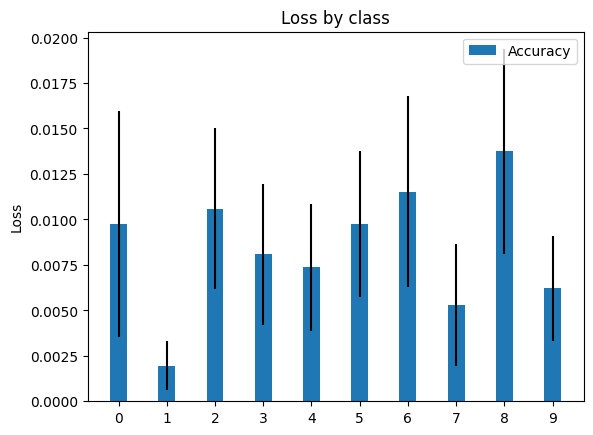

In [21]:
errorbar_classification(np.arange(10), mean_accuracy=mean_accuracy, std_accuracy=std_accuracy)

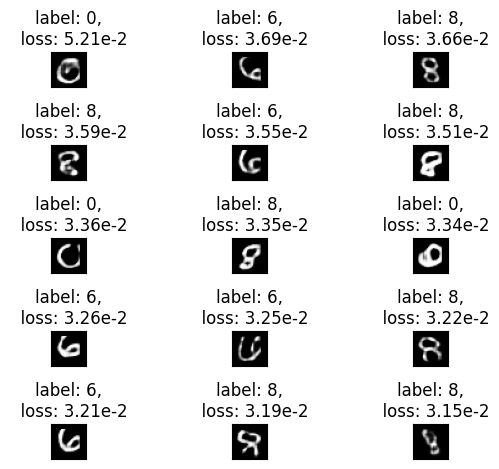

In [22]:
top_anomalous(15, losses, preds.cpu().detach().numpy().reshape(-1, 28, 28), labels)

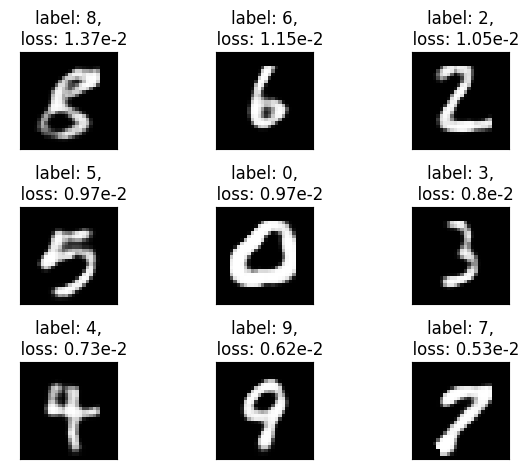

In [23]:
top_mean_anomalous(9, mean_accuracy, preds, labels)